In [1]:
import argparse
import gdown
import cv2
import numpy as np
import os
import sys
sys.path.append(sys.path[0]+"/tracker")
sys.path.append(sys.path[0]+"/tracker/model")
from track_anything import TrackingAnything
from track_anything import parse_augment
import requests
import json
import torchvision
import torch 
from tools.painter import mask_painter
import psutil
import time
try: 
    from mmcv.cnn import ConvModule
except:
    os.system("mim install mmcv")
import matplotlib.pyplot as plt
from pycocotools import mask as maskUtils

In [2]:
ovis_anotations = 'D:/HADA/data/OVIS/annotations/'
ovis_images = 'D:/HADA/data/OVIS/train_images/'

ovis_anotations = '../data.nosync/OVIS/annotations/'
ovis_images = '../data.nosync/OVIS/train_images/'

In [3]:
def cargarDatos(ruta_ann):
    with open(ruta_ann + 'annotations_train.json') as f:
        annotationsTrain = json.load(f)

    with open(ruta_ann + 'annotations_valid.json') as f:
        annotationsValid = json.load(f)

    with open(ruta_ann + 'annotations_test.json') as f:
        annotationsTest = json.load(f)

    clases = annotationsTrain['categories']
    vidTrain = annotationsTrain['videos']
    annTrain = annotationsTrain['annotations']
    vidValid = annotationsValid['videos']
    annValid = annotationsValid['annotations']
    vidTest = annotationsTest['videos']
    annTest = annotationsTest['annotations']

    return clases, vidTrain, annTrain, vidValid, annValid, vidTest, annTest

clases, vidTrain, annTrain, vidValid, annValid, vidTest, annTest = cargarDatos(ovis_anotations) 

In [4]:
def annToRLE(ann, frameId):
    """
    Convert annotation which can be polygons, uncompressed RLE to RLE.
    :return: binary mask (numpy 2D array)
    """
    h, w = ann['height'], ann['width']
    segm = ann['segmentations'][frameId]
    if segm is None:
        return None
    if type(segm) == "list":
        # polygon -- a single object might consist of multiple parts
        # we merge all parts into one mask rle code
        rles = maskUtils.frPyObjects(segm, h, w)
        rle = maskUtils.merge(rles)
    elif type(segm['counts']) == "list":
        # uncompressed RLE
        rle = maskUtils.frPyObjects(segm, h, w)
    else:
        # rle
        rle = segm
    return rle


def annToMask(ann, frameId):
    """
    Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
    :return: binary mask (numpy 2D array)
    """
    rle = annToRLE(ann, frameId)
    if rle is not None:
        m = maskUtils.decode(rle)
        return m



def combineMasks(masks, width, height):
    # Crear una matriz vacía para la máscara combinada
    combined = np.zeros((height, width), dtype=np.uint8)

    # Combinar las máscaras en la matriz vacía
    for mask in masks:
        combined += mask  # Sumar la máscara a la máscara combinada

    # Aplicar umbral para obtener una única máscara binaria
    combined = np.where(combined > 0, 1, 0)
    return combined

def unifyMasks(masks, width, height):
    # Crear una matriz vacía para la máscara combinada
    unified = np.zeros((height, width), dtype=np.uint8)

    # Combinar las máscaras en la matriz vacía
    for mask in masks:
        unified += mask  # Sumar la máscara a la máscara combinada

    
    return unified

In [5]:
def load_images_from_folder(path,image_files):
    images = []
    for file in image_files:
        img = cv2.imread(os.path.join(path,file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
    return images

def load_all_initial_masks_from_dataset():
    all_masks = []
    for video in vidTrain:
        ann = [a for a in annTrain if a['video_id'] == video['id']]
        masks = [annToMask(a, 0) * (i + 1) for i, a in enumerate(ann) if annToMask(a, 0) is not None]
        all_masks.append(unifyMasks(masks, video['width'], video['height']))
    return all_masks

def load_all_masks_for_video(video):
    ann = [a for a in annTrain if a['video_id'] == video['id']]
    all_masks  = []
    for image_num in range(0,video['length']):
        masks = []
        for i, a in enumerate(ann):
            annot = annToMask(a, image_num)
            if annot is not None: masks.append(annot * (i + 1))
        single_mask = unifyMasks(masks, video['width'], video['height'])
        all_masks.append(single_mask)
    return all_masks

def generate_video_from_frames(frames, output_path, fps=30):
    frames = torch.from_numpy(np.asarray(frames))
    if not os.path.exists(os.path.dirname(output_path)):
        os.makedirs(os.path.dirname(output_path))
    torchvision.io.write_video(output_path, frames, fps=fps, video_codec="libx264")
    return output_path

In [6]:
def calculate_iou(mask1, mask2):
    # Ensure both masks have the same shape
    assert mask1.shape == mask2.shape, "Mask shapes must be the same."

    # Calculate intersection and union for each label
    labels = np.unique(np.concatenate((mask1, mask2)))
    intersection = np.zeros_like(mask1, dtype=np.float32)
    union = np.zeros_like(mask1, dtype=np.float32)
    iou_per_label = {}

    for label in labels:
        mask1_label = mask1 == label
        mask2_label = mask2 == label
        c_intersection = np.logical_and(mask1_label, mask2_label)
        c_union = np.logical_or(mask1_label, mask2_label)
        intersection += c_intersection
        union += c_union
        iou_per_label[label] = np.sum(c_intersection) / np.sum(c_union)

    # Calculate IoU
    iou = np.sum(intersection) / np.sum(union)

    return iou, iou_per_label

def compute_f_measure(mask1, mask2):
    # Ensure both masks have the same shape
    assert mask1.shape == mask2.shape, "Mask shapes must be the same."

    # Calculate F-measure for each label
    labels = np.unique(np.concatenate((mask1, mask2)))
    f_measure_per_label = {}

    for label in labels:
        mask1_label = mask1 == label
        mask2_label = mask2 == label

        true_positives = np.logical_and(mask1_label, mask2_label).sum()
        false_positives = np.logical_and(mask1_label, np.logical_not(mask2_label)).sum()
        false_negatives = np.logical_and(np.logical_not(mask1_label), mask2_label).sum()

        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)

        f_measure = 2 * (precision * recall) / (precision + recall)
        f_measure_per_label[label] = f_measure

    return f_measure_per_label

In [7]:
def run_model_on_ovis_set(model,path_set,videos, annotations, compute_metrics = False,save_masks = False, compute_video = False, verbose = True):
    for video in videos:
        # Load all images as np.array
        if verbose: print('Loading dataset images')
        images = load_images_from_folder(path_set,video['file_names'])

        # Load al poligon of first image to a usable mask
        if verbose: print('Creating first annotated mask for VOS model')
        ann = [a for a in annotations if a['video_id'] == video['id']]
        masks = [(annToMask(a, 0) * (i + 1)) for i, a in enumerate(ann)]
        initial_mask = unifyMasks(masks, video['width'], video['height'])

        #Compute masks for all images
        if verbose:print('Computing all masks')
        model.xmem.clear_memory()
        masks, logits, painted_images = model.generator(images=images[0:5], template_mask=initial_mask)
        model.xmem.clear_memory()  

        if compute_metrics:
            if verbose: print('Computing Metrics')
            ground_truth_masks = load_all_masks_for_video(video)
            for i,(mask_infered, mask_gt) in enumerate(zip(masks[1:],ground_truth_masks[1:])):
                f_measure = compute_f_measure(mask_infered,mask_gt)
                iou, iou_per_label = calculate_iou(mask_infered,mask_gt)
                print(f'Mask {i}: f_mesure{f_measure}, iou {iou}, per label {iou_per_label}')
                
        if compute_video: 
            if verbose: print('Generating video')
            generate_video_from_frames(painted_images, output_path="./result/track/{}.mp4".format('Video1'), fps = 30) 

        if save_masks:
            if verbose: print('Saving masks') 
            path_to_masks = './result/mask/{}'.format('Video1')
            if not os.path.exists(path_to_masks): os.makedirs(path_to_masks)
            for i,mask in enumerate(masks): np.save(os.path.join(path_to_masks, '{:05d}.npy'.format(i)), mask)
                
    return masks, logits, painted_images

In [8]:
SAM_checkpoint = "./checkpoints/sam_vit_h_4b8939.pth"
xmem_checkpoint = "./checkpoints/XMem-s012.pth"
e2fgvi_checkpoint = "./checkpoints/E2FGVI-HQ-CVPR22.pth"
args = {'use_refinement':True}
model = TrackingAnything(SAM_checkpoint, xmem_checkpoint, e2fgvi_checkpoint,args)

Initializing BaseSegmenter to cuda:0
Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Sam Refinement ACTIVATED
load pretrained SPyNet...
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmediting/restorers/basicvsr/spynet_20210409-c6c1bd09.pth


In [9]:
masks, logits, painted_images = run_model_on_ovis_set(model = model, path_set = ovis_images,videos = vidTrain[0:1],annotations = annTrain,compute_metrics = False, save_masks=False, compute_video=False)

Loading dataset images
Creating first annotated mask for VOS model
Computing all masks


Tracking image:  20%|██        | 1/5 [00:57<03:51, 57.78s/it]

Sam Refineent entry torch.Size([11, 886, 1920])


/Users/pita/Documents/Universidad/Master/TFM/VideoSegmentation/Code/OWNTAM/.venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Tracking image:  40%|████      | 2/5 [16:19<28:18, 566.11s/it]

Sam Refineent entry torch.Size([11, 886, 1920])


Tracking image:  40%|████      | 2/5 [19:47<29:40, 593.56s/it]


KeyboardInterrupt: 

In [200]:
SAM_checkpoint = "./checkpoints/sam_vit_h_4b8939.pth"
xmem_checkpoint = "./checkpoints/XMem-s012.pth"
e2fgvi_checkpoint = "./checkpoints/E2FGVI-HQ-CVPR22.pth"
args = {'use_refinement':True}
model = TrackingAnything(SAM_checkpoint, xmem_checkpoint, e2fgvi_checkpoint,args)

Initializing BaseSegmenter to cuda:0
Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
load pretrained SPyNet...
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmediting/restorers/basicvsr/spynet_20210409-c6c1bd09.pth


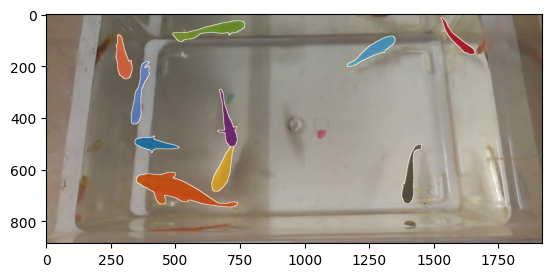

In [11]:
plt.imshow(painted_images[1])

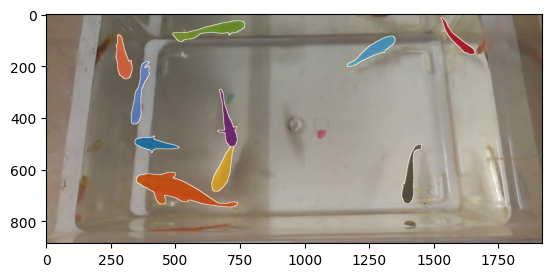

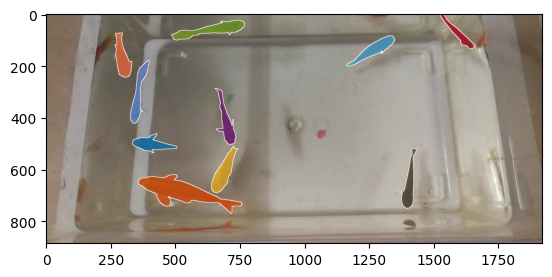

In [99]:
plt.imshow(painted_images[1])
plt.show()
plt.imshow(painted_images[0])
plt.show()

(-0.5, 1919.5, 885.5, -0.5)

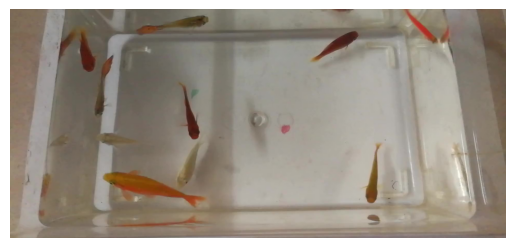

In [17]:
# Lee una imagen y la muestra en una ventanaovis_images + first_video_folder +'/img_0000001.jpg'
img = cv2.imread(os.path.join(ovis_images + first_video_folder +'/img_0000001.jpg'))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')

In [19]:
colors = [
    (255, 0, 0),    # Rojo
    (0, 255, 0),    # Verde
    (0, 0, 255),    # Azul
    (255, 255, 0),  # Amarillo
    (255, 0, 255),  # Magenta
    (0, 255, 255),  # Cian
    (128, 0, 0),    # Marrón oscuro
    (0, 128, 0),    # Verde oscuro
    (0, 0, 128),    # Azul oscuro
    (128, 128, 0),  # Amarillo oscuro
    (128, 0, 128),  # Magenta oscuro
    (0, 128, 128),  # Cian oscuro
    (255, 128, 0),  # Naranja
    (128, 255, 0),  # Lima
    (255, 0, 128),  # Rosa
    (128, 0, 255),  # Violeta
    (0, 255, 128),  # Turquesa
    (0, 128, 255),  # Azul claro
    (255, 128, 128), # Rosa claro
    (128, 255, 128)  # Verde claro
]

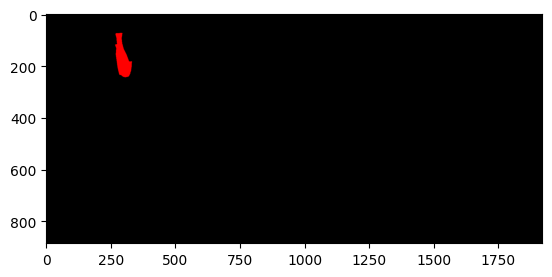

In [20]:
ann = []
video = vidTrain[0]
for a in annTrain:
    if a['video_id'] == video['id']:
        ann.append(a)
        break
    else: continue

mask = annToMask(ann[0], 0)
colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
colored_mask[:, :, 0] = mask * colors[0][0]
colored_mask[:, :, 1] = mask * colors[0][1]
colored_mask[:, :, 2] = mask * colors[0][2]
plt.imshow(colored_mask)

In [21]:
ann = []
for a in annTrain:
    if a['video_id'] == video['id']:
        ann.append(a)
    else: continue

masks = []
for i,a in enumerate(ann):
    m = annToMask(a, 0)
    m = m * (i + 1)
    masks.append(m)

w, h = video['width'], video['height']
unified = unifyMasks(masks, w, h)

In [41]:
model.xmem.clear_memory()
masks, logits, painted_images = model.generator(images=images[0:5], template_mask=unified)
model.xmem.clear_memory()

Tracking image: 100%|██████████| 5/5 [07:05<00:00, 85.01s/it]


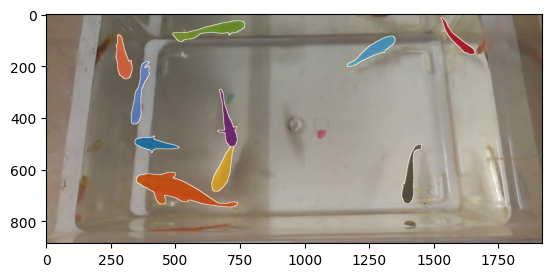

In [44]:
plt.imshow(painted_images[1])

In [87]:
def print_rgb_mask(mask):
    colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    colored_mask[:, :, 0] = mask * colors[0][0]
    colored_mask[:, :, 1] = mask * colors[0][1]
    colored_mask[:, :, 2] = mask * colors[0][2]
    plt.imshow(colored_mask)
    plt.show()
    

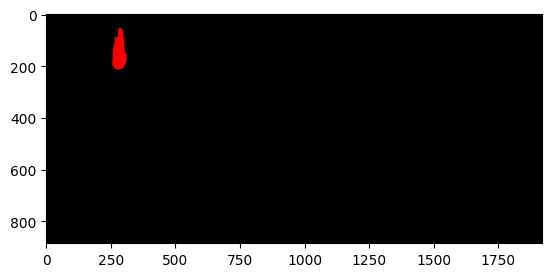

In [98]:
print_rgb_mask(logits[29])

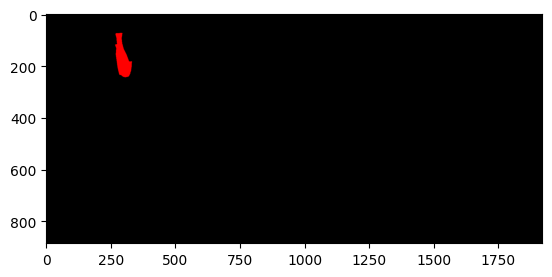

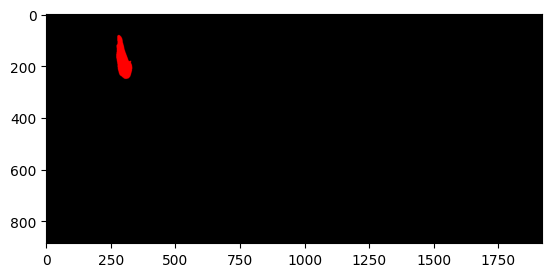

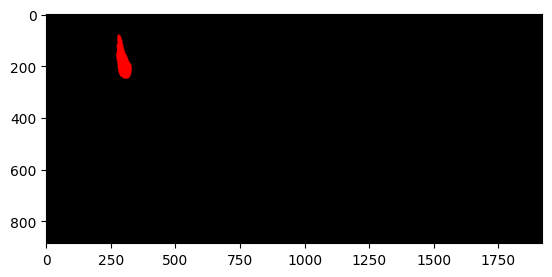

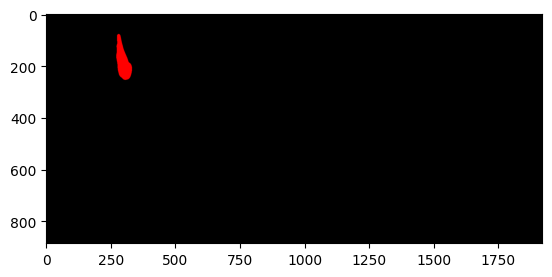

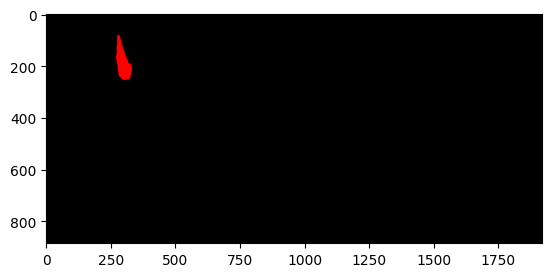

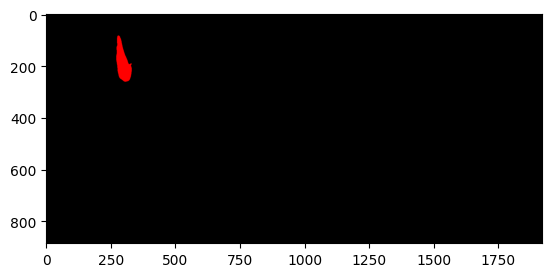

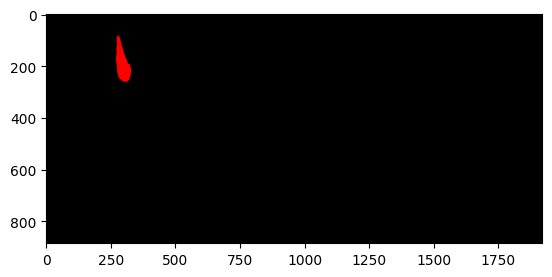

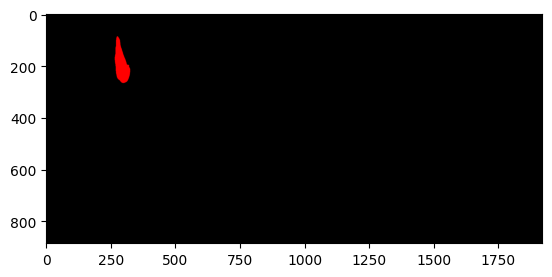

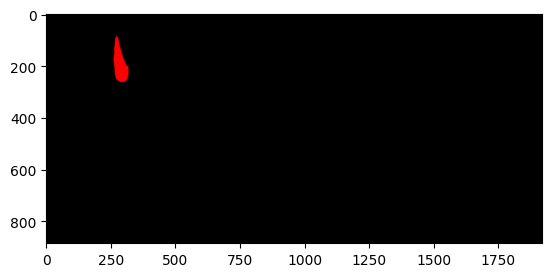

In [44]:
for i in range(0,9):
    colored_mask = np.zeros((masks[i].shape[0], masks[i].shape[1], 3), dtype=np.uint8)
    colored_mask[:, :, 0] = masks[i] * colors[0][0]
    colored_mask[:, :, 1] = masks[i] * colors[0][1]
    colored_mask[:, :, 2] = masks[i] * colors[0][2]
    plt.imshow(colored_mask)
    plt.show()